In [1]:
import os
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import flopy
import shapefile as sf
import pandas as pd
import shapely.geometry as geom
import mplleaflet
import warnings

from mpl_toolkits.axes_grid1 import make_axes_locatable
from flopy.utils.gridgen import Gridgen
from flopy.discretization.structuredgrid import StructuredGrid
from scipy.interpolate import griddata
from flopy.utils.triangle import Triangle as Triangle
from collections import OrderedDict
from shapely.geometry import *
from shapely.strtree import STRtree
from descartes import PolygonPatch
from matplotlib.collections import PatchCollection

flopy is installed in G:\hydro\anaconda3\envs\ropen\lib\site-packages\flopy


In [2]:
import hydroeval
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

In [3]:
print('flopy version: {}'.format(flopy.__version__))

flopy version: 3.3.1


In [4]:
def intersect(mglist, shp, shptype="POLYGON"):
    intersect_dict = {}
    
    s = STRtree(mglist)
    
    result = s.query(shp)
    
    isectshp = []
    cellids = []
    vertices = []
    areas = []
    lengths = []
    
    for i, r in enumerate(result):
        intersect = shp.intersection(r)

        if shptype == "POLYGON":
            if intersect.area > 0.0:
                cellids.append(mglist.index(r))
                isectshp.append(intersect)
                areas.append(intersect.area)
                vertices.append(intersect.__geo_interface__["coordinates"])
        elif shptype == "POLYLINE":
            try:
                isect_iter = iter(intersect)
            except TypeError:
                isect_iter = [intersect]
            
            for isect in isect_iter:
                if isect.length > 0.0:
                    cellids.append(mglist.index(r))
                    isectshp.append(isect)
                    lengths.append(isect.length)
                    vertices.append(isect.__geo_interface__["coordinates"])
        else:
            raise NotImplementedError("shptype '{}' is not supported!".format(shptype))
    
    intersect_dict["intersect"] = isectshp
    intersect_dict["cellids"] = cellids
    intersect_dict["vertices"] = vertices
    if shptype == "POLYGON":
        intersect_dict["areas"] = areas
    elif shptype == "POLYLINE":
        intersect_dict["lengths"] = lengths
    
    return intersect_dict

In [5]:
modelname = 'Fensholt_VoxelUZF'

workspace = os.path.join('.',modelname)
figpth = os.path.join(workspace, 'figures69')

if not os.path.exists(workspace):
    os.makedirs(workspace)

if not os.path.exists(figpth):
    os.makedirs(figpth)

In [6]:
Shortdescription = 'TH = 80' 

f = open(os.path.join(figpth, 'Short_Description'),"w")
f.write(str(Shortdescription))
f.close()

In [7]:
mf = flopy.modflow.Modflow(modelname, exe_name="Exe/MODFLOW-NWT_64.exe", version="mfnwt",model_ws=workspace)

#Definition of MODFLOW NWT Solver
nwt = flopy.modflow.ModflowNwt(mf ,maxiterout=4000, maxitinner=200, linmeth=2, headtol=0.01)

In [8]:
#import data observations
poo = pd.read_csv('Shpfiles/f_piezo_original.csv')
#data_df = pd.read_csv('Shpfiles/F_precip_daily20_21.csv')

In [9]:
list_rch = []
with open('Shpfiles/recharge_fens_mean.txt') as f:
    for line in f:
        inner_list = [elt.strip() for elt in line.split(',')]
        list_rch.append(inner_list)
        
rch_df = pd.DataFrame(list_rch, copy=True)

In [10]:
rch_df.columns = rch_df.iloc[0]
rch_df.rename(columns={rch_df.columns[0]: 'Date'}, inplace=True) 
                       #rch_df.columns[1]: 'recharge (mm/d)'}, inplace = True)

rch_df = rch_df.drop(index=0)
rch_df['Date'] = pd.to_datetime(rch_df["Date"])
rch_df['Date'] = pd.to_datetime(rch_df["Date"].dt.strftime('%Y-%m-%d'))
rch_df = rch_df[rch_df.Date >= pd.to_datetime('2019-10-01')]
rch_df.set_index(pd.to_datetime(rch_df['Date']), inplace=True)
              
rch_df['rech bbox'] = pd.to_numeric(rch_df['rech bbox'])
rch_df['rech bbox w/o river'] = pd.to_numeric(rch_df['rech bbox w/o river'])
rch_df['rech drain catch'] = pd.to_numeric(rch_df['rech drain catch'])
rch_df['rech drain catch w/o paved'] = pd.to_numeric(rch_df['rech drain catch w/o paved'])
rch_df['Pnet drain catch'] = pd.to_numeric(rch_df['Pnet drain catch'])

del rch_df['Date']

In [11]:
rch_df.to_csv(os.path.join(workspace,'F_all_data'+'.csv'))
rch_df.head()

,rech bbox,rech bbox w/o river,rech drain catch,rech drain catch w/o paved,Pnet drain catch
Date,,,,,
2019-10-01,0.103176,0.102103,0.157722,0.103986,-0.028345
2019-10-02,0.172798,0.172666,0.223420,0.165564,0.623374
2019-10-03,0.089103,0.088820,0.123628,0.082200,0.229062
2019-10-04,0.095078,0.095355,0.126598,0.099796,0.291082
2019-10-05,0.088220,0.086944,0.136026,0.072200,-0.518484


In [12]:
rch = pd.DataFrame(rch_df, copy=True)
pet = pd.DataFrame(rch_df, copy=True)
rch[rch['rech bbox']<0] = 0
pet[pet['rech bbox']>0] = 0
pet = pet.abs()

In [13]:
drain_df = pd.read_csv('Shpfiles/f_drnflow_2021_mean.csv')
drain_df.set_index(pd.to_datetime(drain_df['Date']), inplace=True)
del drain_df['Date']
drain_df['Fens'] = drain_df['Fens']*86400/1000 #getting drainage in m^3

data_comp = pd.DataFrame(drain_df['Fens']*86400/1000, copy=True) #getting drainage in m^3 for the comparison dataframe used later

In [14]:
drain_df.head()

,Fens
Date,
2020-01-09,1214.064
2020-01-10,709.092
2020-01-11,536.112
2020-01-12,832.608
2020-01-13,669.312


In [15]:
#import shapefiles to construct model discretization
modellimshp = sf.Reader('Shpfiles/basin_rrf_2020_05_20.shp')
modelpiezoshp = sf.Reader('Shpfiles/f_all_piezo.shp')
modeldrain = sf.Reader('Shpfiles/f_all_drain.shp')

In [16]:
bbox = []
bbox.append(567706.000000) 
bbox.append(6206005.000000)
bbox.append((bbox[0]+(140*10)))
bbox.append((bbox[1]+(120*10)))
print(bbox)

[567706.0, 6206005.0, 569106.0, 6207205.0]


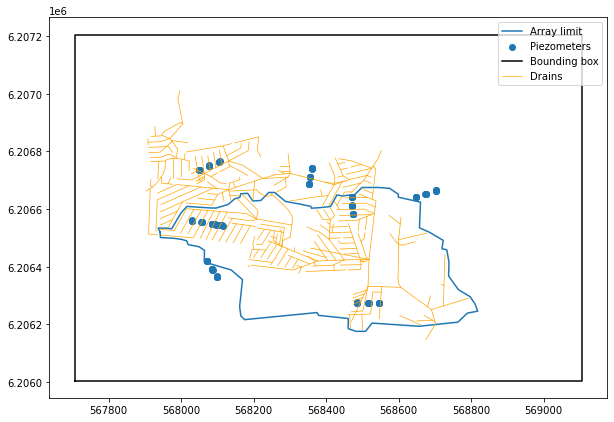

In [17]:
limitarray = np.array(modellimshp.shapeRecords()[0].shape.points)
piezoarray = np.array([point.shape.points[0] for point in modelpiezoshp.shapeRecords()])
drain_coords = []
#bbox = modellimshp.bbox

for i in np.arange(len(modeldrain.shapeRecords())):
    drain_coords = drain_coords + [modeldrain.shapeRecords()[i].shape.points[:]]    
    
drain_mls = MultiLineString(drain_coords)
    
fig = plt.figure(figsize=(10,7))
limitlines, = plt.plot(limitarray[:,0],limitarray[:,1])
limitbbox, = plt.plot([bbox[0], bbox[0], bbox[2], bbox[2], bbox[0]], [bbox[1], bbox[3], bbox[3], bbox[1], bbox[1]], color='black')
piezoscatter = plt.scatter(piezoarray[:,0],piezoarray[:,1])
for ig in drain_mls.geoms:
    drainlines, = plt.plot(ig.xy[0], ig.xy[1], color='orange', linewidth=0.7)

    
plt.show;
plt.legend([limitlines,piezoscatter,limitbbox,drainlines],['Array limit','Piezometers','Bounding box','Drains'],loc='upper right');

In [18]:
fig = plt.figure(figsize=(20,9))
plt.plot([bbox[0], bbox[0], bbox[2], bbox[2], bbox[0]], [bbox[1], bbox[3], bbox[3], bbox[1], bbox[1]], color='black')
plt.plot(limitarray[:,0],limitarray[:,1])
plt.show

crs = {'init' : 'epsg:25832'}
mplleaflet.display(fig,crs=crs)

G:\hydro\anaconda3\envs\ropen\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
G:\hydro\anaconda3\envs\ropen\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
G:\hydro\anaconda3\envs\ropen\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making th

In [19]:
cbc_unit = 53 #binary number in which flows are saved

In [20]:
threshold = 80
hks = np.load('Shpfiles/threshold_array_th=80') #hks is made from threshold of 65 ohmm. 
res_arr = np.load('Shpfiles/res_array_real10')
print(hks.shape, res_arr.shape)

(12, 120, 140) (12, 120, 140)


In [21]:
#start discretization of model
nrows = hks.shape[1]
ncols = hks.shape[2]

delR = np.zeros(ncols)
delC = np.zeros(nrows)

for i in range(ncols):
    delR[i] = (bbox[2]-bbox[0])/ncols

for j in range(nrows):
    delC[j] = (bbox[3]-bbox[1])/nrows

nlay = hks.shape[0]
mtop = 1
botm = np.arange(nlay)

nper =  len(rch_df['rech bbox']) #1 years stres period
perlen = np.ones(nper)
perlen[0] = 1
perlen[1:] = 1  #1 day

nstp = np.ones(nper) #number og time steps must be equal to nper.
nstp[0] = 1 #steady state
nstp[1:] = 1 #length of each timestep, 10 timesteps pr day

tsmult = 1
itmuni = 4 #days
lenuni = 2 #meters

periodType = np.zeros(nper, dtype=bool)
periodType[0] = True

dis = flopy.modflow.ModflowDis(mf, nlay=nlay,
                               nrow=nrows,ncol=ncols,
                               delr=delR,delc=delC,
                               top=mtop,botm=botm,
                               itmuni=itmuni,lenuni=lenuni,nper=nper,
                               perlen=perlen,nstp=nstp,
                               tsmult=tsmult,steady=periodType,
                               xul=bbox[0], yul= bbox[3], start_datetime = '2020-09-10')

print('nrows = {}'.format(nrows), 'ncols = {}'.format(ncols),
      'nlay = {}'.format(nlay), 'nper ={}'.format(nper))

nrows = 120 ncols = 140 nlay = 12 nper =532


In [22]:
mf.dis.structuredgrid = StructuredGrid(delr=delR,delc=delC,epsg=25832)
mf.modelgrid.set_coord_info(xoff=bbox[0], yoff=bbox[3]-delC.sum(), angrot=0,epsg=25832)

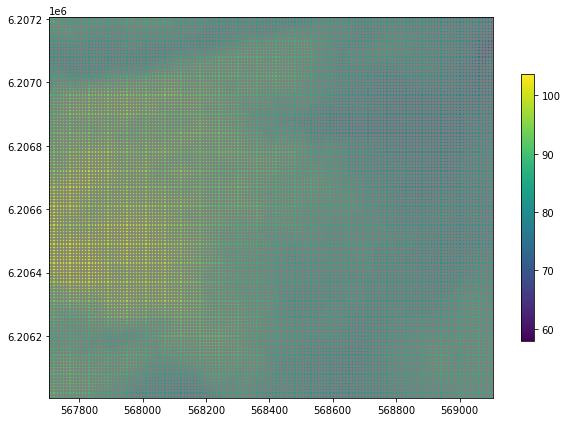

In [23]:
fens_dem = flopy.utils.Raster.load("Shpfiles/DTM_2020_05_07_crop.TIF") #DEM used

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

ax = fens_dem.plot(ax=ax)
plt.colorbar(ax.images[0], shrink=0.7);
pmv = flopy.plot.PlotMapView(modelgrid=mf.modelgrid)
pmv.plot_grid(ax=ax)

In [24]:
#Interpolation of DEM into MODFLOW grid using nearest neighbor
t0 = time.time()
dem_data = fens_dem.resample_to_grid(mf.modelgrid.xcellcenters,
                                mf.modelgrid.ycellcenters,
                                band=fens_dem.bands[0],
                                method="nearest")
resample_time = time.time() - t0
print("Resample time, nearest neighbor: {:.3f} sec".format(time.time() - t0))

Resample time, nearest neighbor: 10.121 sec


In [25]:
#Setting up layers for the modflow model
mtop = dem_data

zbot = np.zeros((nlay,nrows,ncols))
bot_thick = 10
botm = mtop-bot_thick-(nlay-1)*0.5
t = 0.5 #thickness of 1 meter

for n in range(nlay-1):
    zbot[n,:,:] = mtop[:,:]-t
    t = t+0.5

zbot[-1,:,:] = botm
#Asign layer bottom elevations
mf.dis.botm = zbot
mf.dis.top  = mtop #set model top to DEM

In [26]:
#assigning hydraulic conductivity values in m/d and specific yield values for the geological units sand and clay
k_values = {'hk_sand':[86400*1.2e-3],
            'hk_clay':[86400*1.2e-7]}

sy_values = {'sy_sand':[0.24],
            'sy_clay':[0.01]}

In [27]:
grid_cells = []

nx = ncols
ny = nrows

x0, y0 = bbox[0], bbox[1]
dx, dy = (bbox[2]-bbox[0])/ncols, (bbox[3]-bbox[1])/nrows

for i in range(ny):
    for j in range(nx):
        x = x0+j*dx
        y = y0+i*dy
        xy = [[x, y], [x+dx, y], [x+dx, y+dy], [x, y+dy], [x, y]]
        grid_cells.append(Polygon(xy))

In [28]:
poly_intersect = Polygon(limitarray)

In [29]:
result1 = intersect(grid_cells, poly_intersect, shptype="POLYGON")

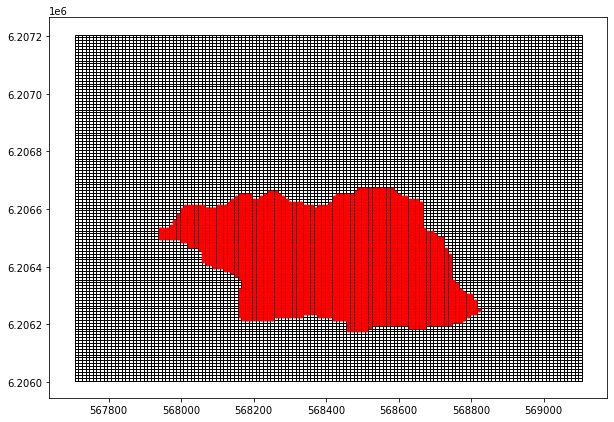

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

for g in grid_cells:
    pp = PolygonPatch(g, edgecolor="k", alpha=1.0, facecolor="none")
    ax.add_patch(pp)

for i, ishp in enumerate(result1["intersect"]):
    ppi = PolygonPatch(ishp, facecolor="C{}".format(10), alpha=0.5)
    ax.add_patch(ppi)
        
for cid in result1["cellids"]:
    c = grid_cells[cid].centroid
    ax.plot(c.x, c.y, "r.")

plt.show()

In [31]:
result2 = intersect(grid_cells, drain_mls, shptype="POLYLINE")

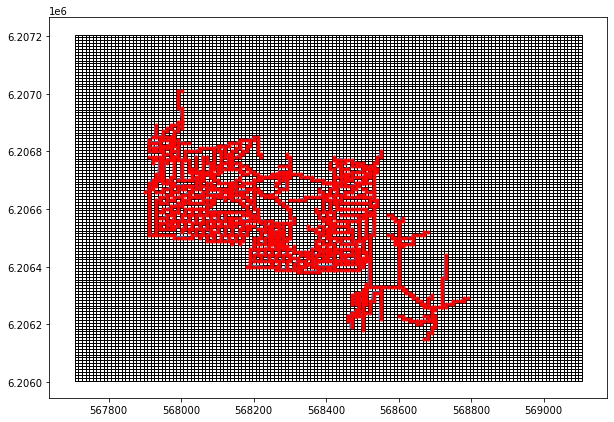

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

for g in grid_cells:
    pp = PolygonPatch(g, edgecolor="k", alpha=1.0, facecolor="none")
    ax.add_patch(pp)

for i, ishp in enumerate(result2["intersect"]):
    ax.plot(ishp.xy[0], ishp.xy[1], ls="-", c="C{}".format(10))
        
for cid in result2["cellids"]:
    c = grid_cells[cid].centroid
    ax.plot(c.x, c.y, "r.")

plt.show()

In [33]:
ibound = np.zeros([nlay,nrows,ncols])

for k in result1["cellids"]:
    for i in range(nrows):
        a_range = np.arange((ncols*i), (ncols*(i+1)))
        a_list = list(a_range)
        try:
            index = a_list.index(k)
            ibound[:,i,index] = 1
        except ValueError:
            continue

In [34]:
ibound = ibound[:,::-1,:]
strt = mtop
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)

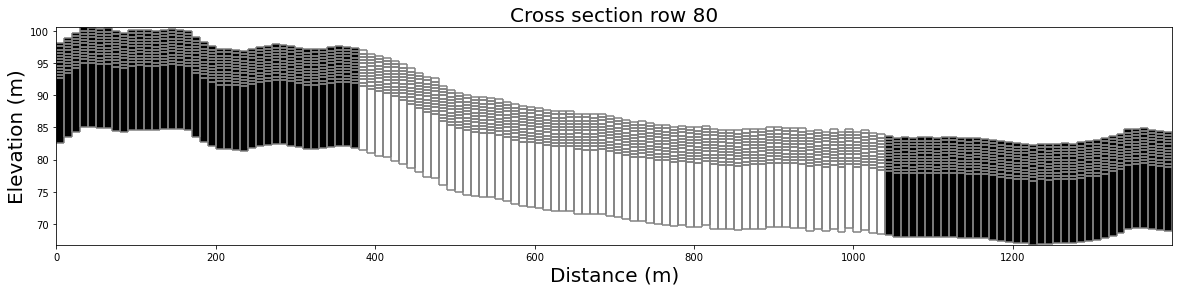

In [35]:
#after generating the bas file, lets illustrate the setup in a cross section
fig = plt.figure(figsize=(20, 4))
ax = fig.add_subplot(1, 1, 1)
modelxsect = flopy.plot.PlotCrossSection(model=mf, line={'row': 80})
linecollection = modelxsect.plot_grid()
modelxsect.plot_ibound(ibound=ibound)
ax.set_ylabel('Elevation (m)', fontsize=20)
ax.set_xlabel('Distance (m)', fontsize=20)
ax.set_title('Cross section row 80', fontsize=20)
fig.savefig(os.path.join(figpth, 'CrossSection_Row80'),transparent=False, bbox_inches='tight', pad_inches=0.05)

In [36]:
#Generating array with hydraulic conductivity values 
hkarray = np.copy(hks)

hkarray[hks == 1] = k_values['hk_clay']
hkarray[hks == 2] = k_values['hk_sand']

hkarray[ibound == 0] = 0.0

In [37]:
#creating a 3D grid for specific yield with same shape as the hydraulic conductivites
sy = np.copy(hkarray)
sy[hkarray == k_values['hk_sand']] = sy_values['sy_sand']
sy[hkarray == k_values['hk_clay']] = sy_values['sy_clay']

In [38]:
#Setup of the UPW package
laytyp = np.ones(nlay)
upw = flopy.modflow.ModflowUpw(mf, ipakcb = cbc_unit, laytyp = laytyp, hk = hkarray, vka =hkarray, laywet=0,
                              ss=09.2e-4, sy=sy)

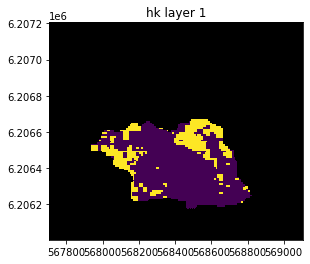

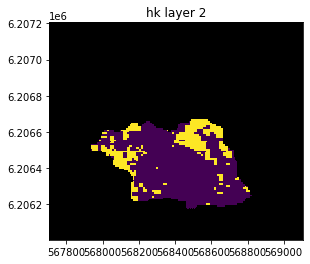

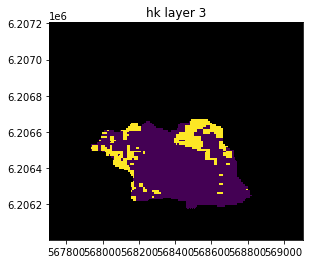

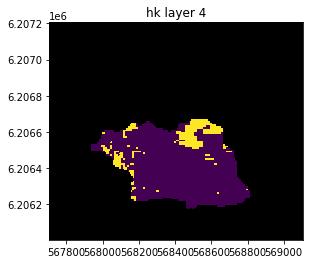

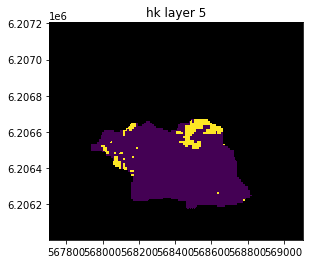

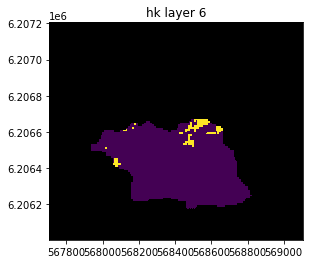

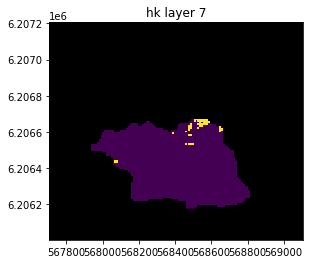

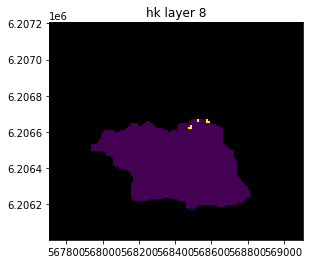

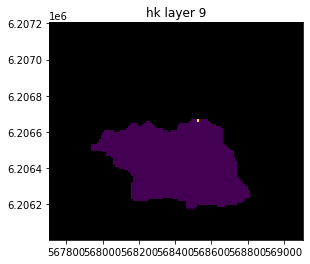

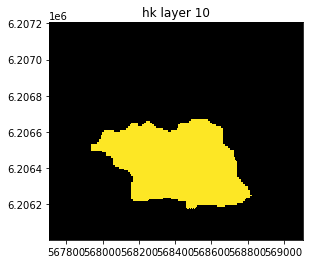

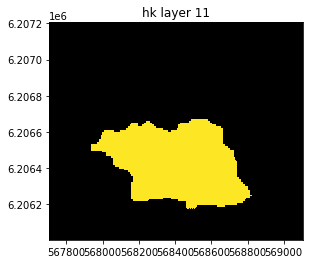

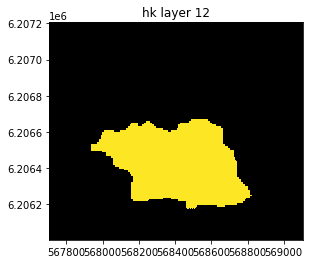

In [39]:
mf.upw.hk.plot();

In [40]:
infrate = rch['rech bbox']/1000 #to get precip in m 
finf = []
farray = np.zeros([nrows,ncols])

for i in range(nper):
    inf = farray+infrate[i]
    finf.append(inf)

finf = {i: finf[i] for i in range(nper)}

In [41]:
pet = pet['rech bbox']/1000 #to get precip in m 
pet_arr = []
parray = np.zeros([nrows,ncols])

for i in range(nper):
    et = parray+pet[i]
    pet_arr.append(et)

pet_arr = {i: pet_arr[i] for i in range(nper)}

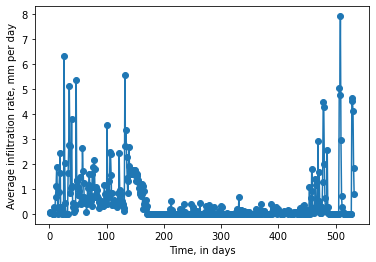

In [42]:
plt.plot(mf.dis.perlen.array.cumsum(), 
         [a.mean() * nper for a in finf.values()], marker='o')
plt.xlabel('Time, in days')
plt.ylabel('Average infiltration rate, mm per day');

In [43]:
#fetching hydraulic head data and getting piezometer locations
pobs_df = pd.DataFrame(poo, copy=True)

F_3_1_D_i = pobs_df[pobs_df['Piezo']=='F-3-1-D'].index.values.min()
F_3_2_D_i = pobs_df[pobs_df['Piezo']=='F-3-2-D'].index.values.min()
F_3_3_D_i = pobs_df[pobs_df['Piezo']=='F-3-3-D'].index.values.min()

In [44]:
hc = []
hr = []
for i in [F_3_1_D_i,F_3_2_D_i,F_3_3_D_i]:
    hc.append(((pobs_df.iloc[i][1]-bbox[0])/mf.dis.delc[0]).astype(int))
    hr.append((mf.dis.nrow-(pobs_df.iloc[i][2]-bbox[1])/mf.dis.delr[0]).astype(int))
    

In [45]:
uzgag = {-68: [-68],
         65: [hr[0].astype(int), hc[0].astype(int), 65, 1], #Print time, head, uz thickness and cum. vols of infiltration, recharge, storage, change in storage and ground-water discharge to land surface.
         66: [hr[1].astype(int), hc[1].astype(int), 66, 2], #Same as option 1 except rates of infiltration, recharge, change in storage, and ground-water discharge also are printed.
         67: [hr[2].astype(int), hc[2].astype(int), 67, 3]} #Prints time, ground-water head, thickness of unsaturated zone, followed by a series of depths and water contents in the unsaturated zone.

In [46]:
#setup of usaturated zone simulation parameters in the UZF1 pakcage
uzf = flopy.modflow.ModflowUzf1(mf,
                                nwt_11_fmt=True,
                                nuztop=3, iuzfopt=2, irunflg=0, ietflg=1,
                                ipakcb=cbc_unit, 
                                iuzfcb2=61,# binary output of recharge and groundwater discharge
                                ntrail2=15, nsets=20,
                                surfdep=1.0, uzgag=uzgag,
                                iuzfbnd=mf.bas6.ibound.array[0,:,:],  
                                vks=hkarray[0,:,:], # saturated vertical hydraulic conductivity of the uz
                                finf=finf, #infiltration rates
                                eps=3.5, # Brooks-Corey relation of water content to hydraulic conductivity (epsilon)
                                thts = 0.35,
                                pet=pet_arr,
                                extdp=2, # saturated water content of the uz in units of volume of water to total volume
                                unitnumber=19)

In [47]:
#Getting drain locations on grid and generating a grid with drain locations
drnbound = np.zeros([nrows,ncols])

for k in result2["cellids"]:
    for i in range(nrows):
        a_range = np.arange((ncols*i), (ncols*(i+1)))
        a_list = list(a_range)
        try:
            index = a_list.index(k)
            drnbound[i,index] = 1
        except ValueError:
            continue
            
drnbound = drnbound[::-1,:]
drnbound[ibound[2,:,:]==0] = 0

In [48]:
#setup of drain package DRN
drncond = 4 #to get drn in m^3/d
drn_elev = 0.9 #drn layer = 1 (python syntax)
lrcec = {}
array = []
arrays = []

for n in range(nper):
    for i in range(len(drnbound[:,0])):
        for j in range(len(drnbound[0,:])):
            if drnbound[i,j]==1:
                array = [1,i,j,(mtop[i,j]-drn_elev),drncond]
                arrays.append(array)
                array = []
            else:
                continue

lrcec[0] = arrays
drn = flopy.modflow.ModflowDrn(mf, ipakcb = cbc_unit, stress_period_data = lrcec)

In [49]:
#dictionary of piezometer names
piezo_dict = ['F_1_2_D', 
              'F_3_1_D', 
              'F_3_2_C',
              'F_3_2_D',
              'F_3_2_E',
              'F_3_3_D',
              'F_4_2_D',
              'F_5_2_D',
              'F_6_2_D',
              'F_7_2_D']

In [50]:
#dictionary of piezometer names

piezo_dict2 = ['F-1-2-D', 
              'F-3-1-D', 
              'F-3-2-C',
               'F-3-2-D',
              'F-3-2-E',
              'F-3-3-D',
              'F-4-2-D',
              'F-5-2-D',
              'F-6-2-D',
              'F-7-2-D']

In [51]:
dm_df = pd.read_csv('Shpfiles/daily_mean.csv')

In [52]:
dm_df.head()

,Unnamed: 0,"Abs Pres, kPa (F_1_2_D)","Temp, °C (F_1_2_D)","Abs Pres, kPa (F_3_1_D)","Temp, °C (F_3_1_D)","Abs Pres, kPa (F_3_2_C)","Temp, °C (F_3_2_C)","Abs Pres, kPa (F_3_2_E)","Temp, °C (F_3_2_E)","Abs Pres, kPa (F_3_3_D)",...,Depth wt cm (F_3_3_D),Quota m (F_3_3_D),Depth wt cm (F_4_2_D),Quota m (F_4_2_D),Depth wt cm (F_5_2_D),Quota m (F_5_2_D),Depth wt cm (F_6_2_D),Quota m (F_6_2_D),Depth wt cm (F_7_2_D),Quota m (F_7_2_D)
0,2020-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-08-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-08-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-08-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-08-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
poo = pd.DataFrame()
for i in range(len(piezo_dict)):
    poo = pd.concat([poo, dm_df['Quota m ({})'.format(piezo_dict[i])]], axis=1, sort=False)
    
poo.index = pd.to_datetime(dm_df['Unnamed: 0'])
poo.index.name = 'Date'
poo = poo[poo.index > '2020-11-10']
poo = poo.T
poo['mean'] = poo.mean(axis=1)

In [54]:
poo2 = pd.read_csv('Shpfiles/f_piezo_original.csv')

In [55]:
poo2['Piezo'] = poo2['Piezo'].astype(str)

In [56]:
new_df = pd.DataFrame()
for i in range(len(piezo_dict2)):
    new_df = new_df.append(poo2[poo2['Piezo'] == '{}'.format(piezo_dict2[i])])

In [57]:
new_df = new_df.append({'Piezo': 'F-3-2-E', 'East': 568057.01, 'North': 6206554.28, 'Elevation': 97.35}, ignore_index=True)
new_df = new_df[['Piezo', 'East', 'North', 'Elevation']]
new_df = new_df.sort_values(by='Piezo')

In [58]:
new_df.head()

,Piezo,East,North,Elevation
0,F-1-2-D,568355.38,6206712.39,90.86
1,F-3-1-D,568030.97,6206559.52,97.55
2,F-3-2-C,568057.02,6206554.17,97.10
3,F-3-2-D,568057.64,6206554.10,97.06
9,F-3-2-E,568057.01,6206554.28,97.35


In [59]:
#HyD package
wel_df = new_df[['Piezo','East','North']].copy()
wel_df['PCKG'] = 'BAS'
wel_df['ARR'] = 'HD'
wel_df['INTYP'] = 'I'
for i in ['North']:
    wel_df[i] = ((wel_df[i]-bbox[1])).astype(int) # adjust to python syntax
for i in ['East']:
    wel_df[i] = ((wel_df[i]-bbox[0])).astype(int) # adjust to python syntax
layer = np.ones(len(wel_df['Piezo'])).astype(int)
wel_df['Layer'] = layer
cols = ['PCKG','ARR','INTYP','Layer','East','North','Piezo']
hyd_df = wel_df.copy()
hyd_rec = hyd_df[cols].values
hyd = flopy.modflow.ModflowHyd(mf, nhyd=hyd_rec.shape[0], obsdata=hyd_rec, unitnumber=71)

In [60]:
#Output Control package
oc_spd = {}
for i in range(mf.dis.nstp.shape[0]):
    oc_spd[(i,0)] = ['save head', 'save budget']

oc = flopy.modflow.ModflowOc(mf, stress_period_data=oc_spd)

In [61]:
#Before running the model, lets do a quick inspection of a part of the model setup

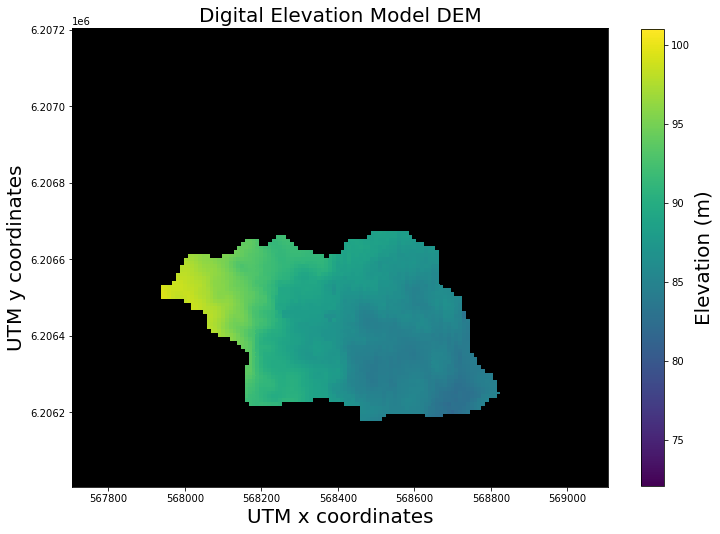

In [62]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

pmv = flopy.plot.PlotMapView(modelgrid=mf.modelgrid, ax=ax)
ax1 = pmv.plot_array(dem_data)
ax2 = pmv.plot_ibound()
ax.set_title('Digital Elevation Model DEM', fontsize = 20)
cb = plt.colorbar(ax1, shrink=0.7);
cb.set_label(label='Elevation (m)', fontsize = 20)
ax.set_ylabel('UTM y coordinates', fontsize=20)
ax.set_xlabel('UTM x coordinates', fontsize=20)
fig.savefig(os.path.join(figpth, 'Model_DEM'),transparent=False, bbox_inches='tight', pad_inches=0.05)

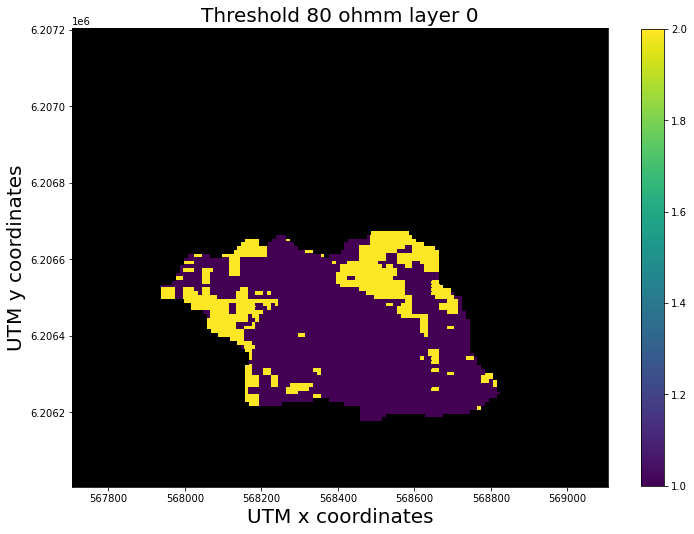

In [63]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

pmv = flopy.plot.PlotMapView(modelgrid=mf.modelgrid, ax=ax)
ax1 = pmv.plot_array(hks[0])
ax2 = pmv.plot_ibound()
ax.set_title('Threshold 80 ohmm layer 0', fontsize = 20)
cb = plt.colorbar(ax1, shrink=0.7, );
ax.set_ylabel('UTM y coordinates', fontsize=20)
ax.set_xlabel('UTM x coordinates', fontsize=20)
fig.savefig(os.path.join(figpth, 'Model_threshold_l0_TH80'),transparent=False, bbox_inches='tight', pad_inches=0.05)

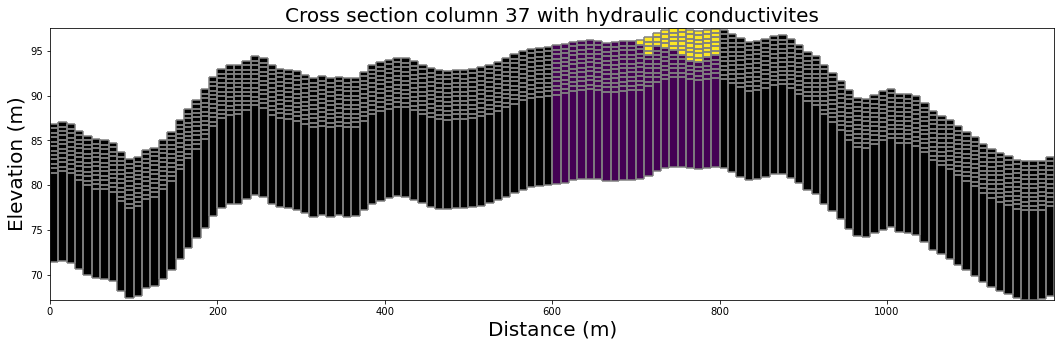

In [64]:
#Inspection of the vertical hydraulic conductivities
fig = plt.figure(figsize=(18, 5))
ax = fig.add_subplot(1, 1, 1)
modelxsect = flopy.plot.PlotCrossSection(model=mf, line={'Column': hc[2]})
linecollection = modelxsect.plot_grid()
modelxsect.plot_array(hkarray)
modelxsect.plot_ibound(ibound=ibound)
ax.set_ylabel('Elevation (m)', fontsize=20)
ax.set_xlabel('Distance (m)', fontsize=20)
ax.set_title('Cross section column {} with hydraulic conductivites'.format(hc[2]), fontsize=20)
fig.savefig(os.path.join(figpth, 'th_80_CrossSection_Column{}'.format(hc[2])),transparent=False, bbox_inches='tight', pad_inches=0.05)

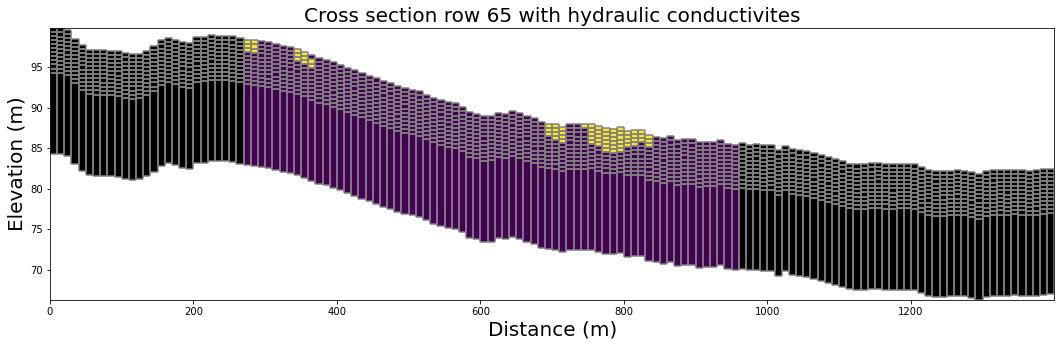

In [65]:
#Inspection of the vertical hydraulic conductivities
fig = plt.figure(figsize=(18, 5))
ax = fig.add_subplot(1, 1, 1)
modelxsect = flopy.plot.PlotCrossSection(model=mf, line={'Row': hr[2]})
linecollection = modelxsect.plot_grid()
modelxsect.plot_array(hkarray)
modelxsect.plot_ibound(ibound=ibound)
ax.set_ylabel('Elevation (m)', fontsize=20)
ax.set_xlabel('Distance (m)', fontsize=20)
ax.set_title('Cross section row {} with hydraulic conductivites'.format(hr[2]), fontsize=20)
fig.savefig(os.path.join(figpth, 'th_80_CrossSection_Row{}'.format(hr[2])),transparent=False, bbox_inches='tight', pad_inches=0.05)

In [66]:
mf.write_input()

In [67]:
mf.run_model()

FloPy is using the following  executable to run the model: Exe/MODFLOW-NWT_64.exe

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.2.0 03/01/2020                        
                    BASED ON MODFLOW-2005 Version 1.12.0 02/03/2017                       

                    SWR1 Version 1.04.0 09/15/2016                       

 Using NAME file: Fensholt_VoxelUZF.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2021/06/10  8:30:02

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     4    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     5    Time step:     1    Groundwater-Flow E

(True, [])

In [68]:
mfheads = flopy.utils.HeadFile('Fensholt_VoxelUZF/Fensholt_VoxelUZF.hds')

In [69]:
totim=100
h = mfheads.get_data(totim=totim)
head = h
head[head == -999.99] = np.nan

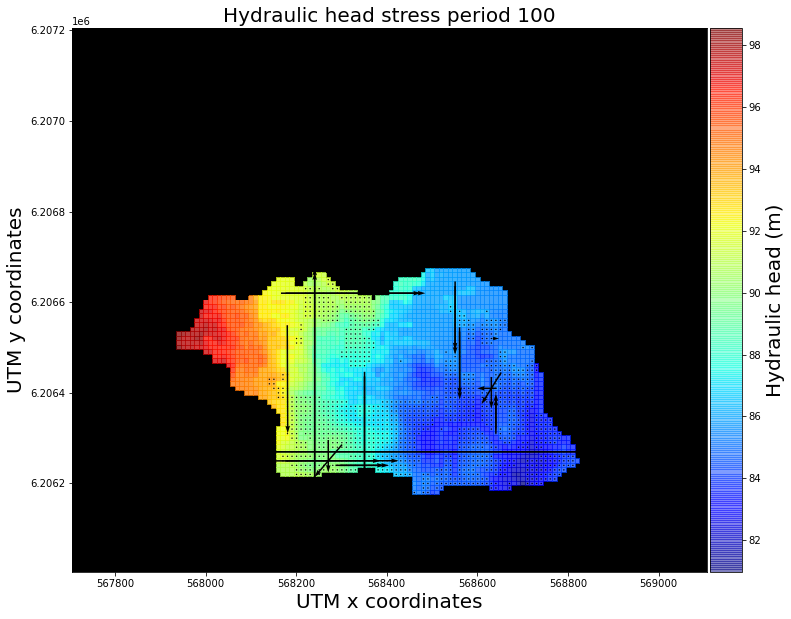

In [70]:
# Plot the heads for a defined layer and boundary conditions
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1)
modelmap = flopy.plot.PlotMapView(model=mf, layer=0)
#quadmesh = modelmap.plot_grid()
quadmesh = modelmap.plot_ibound()
quadmesh = modelmap.plot_bc('drn')
quadmesh = modelmap.plot_array(h, masked_values=[-999.99], alpha=0.5,cmap='jet')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(quadmesh, cax=cax, shrink=0.5)
cb.set_label(label='Hydraulic head (m)', fontsize=20)
ax.set_title('Hydraulic head stress period 100', fontsize=20);
ax.set_ylabel('UTM y coordinates', fontsize=20)
ax.set_xlabel('UTM x coordinates', fontsize=20)

cbb = flopy.utils.CellBudgetFile(os.path.join(workspace, modelname+'.cbc'))
frf = cbb.get_data(totim=totim, text='FLOW RIGHT FACE')[0]
fff = cbb.get_data(totim=totim, text='FLOW FRONT FACE')[0]
quiver = modelmap.plot_discharge(frf, fff, head = h)

fig.savefig(os.path.join(figpth, 'mapview_heads_L0'+'_totim={}'.format(totim)),transparent=False, bbox_inches='tight', pad_inches=0.05)

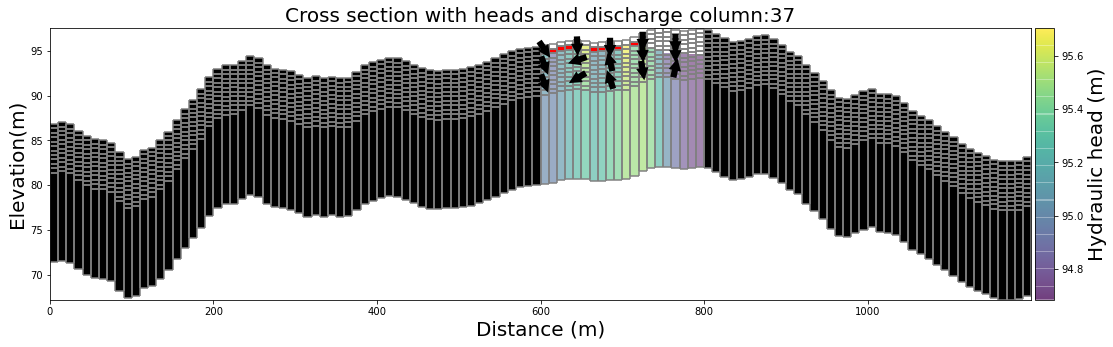

In [71]:
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(model=mf, cbcfile=os.path.join(workspace, modelname+'.cbc'), 
                                                               totim=totim, hdsfile=os.path.join(workspace, modelname+'.hds'))

fig = plt.figure(figsize=(18, 5))
ax = fig.add_subplot(1, 1, 1)

ax.set_title('Cross section with heads and discharge column:{}'.format(hc[2]), fontsize=20)
xsect = flopy.plot.PlotCrossSection(model=mf, ax=ax, line={'Column': hc[2]})
csa = xsect.plot_array(head, masked_values=[-999.99], head=head, alpha=0.5)
patches = xsect.plot_ibound(head=head)
linecollection = xsect.plot_grid()
quiver = xsect.plot_vector(qx, qy, qz, head=head, kstep = 4,
                           hstep=4, normalize=True, color='black', 
                           scale=50, headwidth=2, headlength=2, headaxislength=2,
                           zorder=10)

xsect.plot_bc('drn', color='red')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05)
cb = plt.colorbar(csa, cax=cax, shrink=0.75)
cb.set_label(label='Hydraulic head (m)', fontsize=20)
ax.set_ylabel('Elevation(m)', fontsize=20)
ax.set_xlabel('Distance (m)', fontsize=20)
fig.savefig(os.path.join(figpth, 'th_80_cross_section_column_{}_with_heads_drn_totim=100'.format(hc[2])),transparent=False, bbox_inches='tight', pad_inches=0.05)

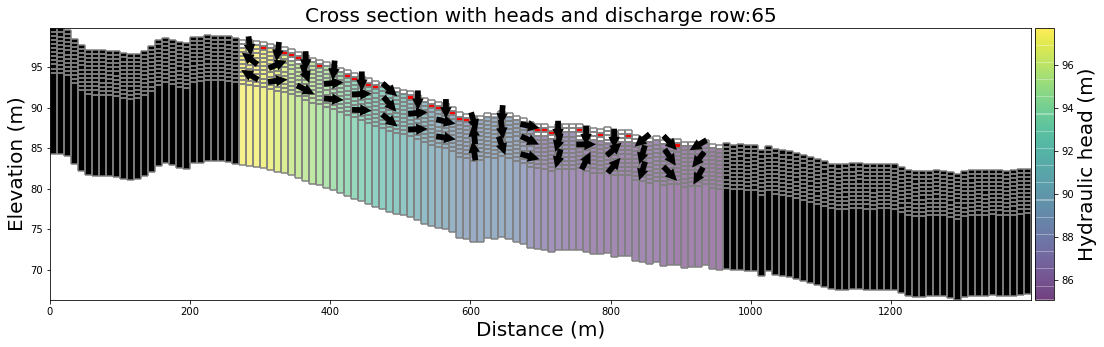

In [72]:
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(model=mf, cbcfile=os.path.join(workspace, modelname+'.cbc'), 
                                                               totim=totim, hdsfile=os.path.join(workspace, modelname+'.hds'))

fig = plt.figure(figsize=(18, 5))
ax = fig.add_subplot(1, 1, 1)

ax.set_title('Cross section with heads and discharge row:{}'.format(hr[2]), fontsize=20)
xsect = flopy.plot.PlotCrossSection(model=mf, ax=ax, line={'row': hr[2]})
csa = xsect.plot_array(head, masked_values=[-999.99], head=head, alpha=0.5)
patches = xsect.plot_ibound(head=head)
linecollection = xsect.plot_grid()
quiver = xsect.plot_vector(qx, qy, qz, head=head, kstep = 4,
                           hstep=4, normalize=True, color='black', 
                           scale=50, headwidth=2, headlength=2, headaxislength=2,
                           zorder=10)
xsect.plot_bc('drn', color='red')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05)
cb = plt.colorbar(csa, cax=cax, shrink=0.75)
cb.set_label(label='Hydraulic head (m)', fontsize=20)
ax.set_ylabel('Elevation (m)', fontsize=20)
ax.set_xlabel('Distance (m)', fontsize=20)
fig.savefig(os.path.join(figpth, 'th_80_cross_section_row_{}_with_heads_drn_totim=100'.format(hr[2])),transparent=False, bbox_inches='tight', pad_inches=0.05)

In [73]:
r = np.zeros([nlay, nrows, ncols])
c = np.zeros([nlay, nrows, ncols])
r[:,hr[2],:] = 1
c[:,:,hc[2]] = 1

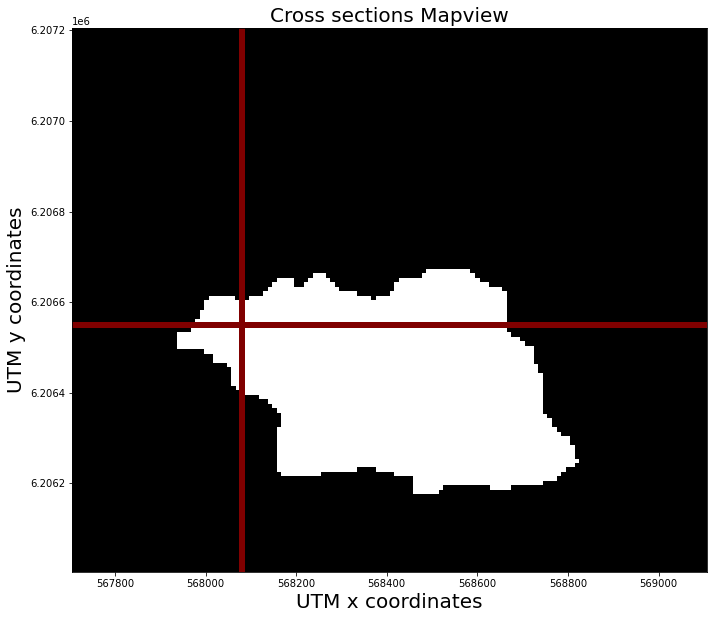

In [74]:
# Plot the column and row for the cross sections above
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1)
modelmap = flopy.plot.PlotMapView(model=mf, layer=0)
#quadmesh = modelmap.plot_grid()
quadmesh = modelmap.plot_ibound()
quadmesh = modelmap.plot_array(r, masked_values=[0], alpha=1,cmap='jet_r')
quadmesh = modelmap.plot_array(c, masked_values=[0], alpha=1,cmap='jet_r')
ax.set_ylabel('UTM y coordinates', fontsize=20)
ax.set_xlabel('UTM x coordinates', fontsize=20)
ax.set_title('Cross sections Mapview', fontsize=20)

fig.savefig(os.path.join(figpth, 'mapview_cross_sections'),transparent=False, bbox_inches='tight', pad_inches=0.05)

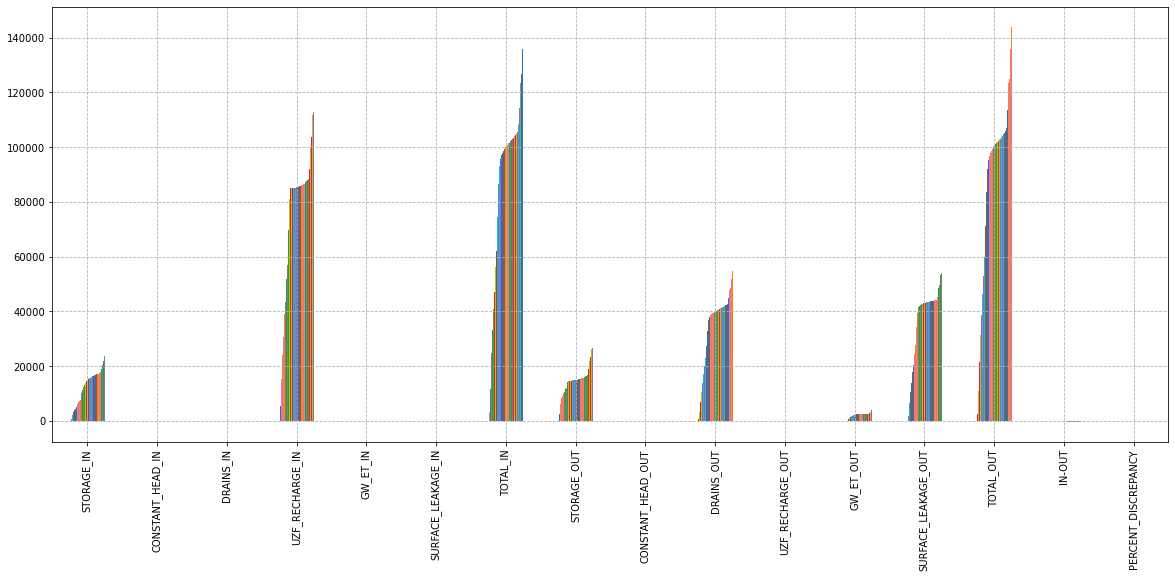

In [75]:
mfl = flopy.utils.MfListBudget(os.path.join(workspace, modelname+'.list'))
incrementaldf, cumulativedf = mfl.get_dataframes()
cum = cumulativedf.T
cum.to_csv(os.path.join(figpth, 'out_mass_balance_'+'.csv'),index_label='Component')

fig,ax = plt.subplots(figsize=(20,8))
cum.plot(ax=ax, kind='bar', legend=False)
ax.grid(ls='--')
fig.savefig(os.path.join(figpth, 'out_mass_balance_'+'.png'),
            transparent=False, bbox_inches='tight', pad_inches=0.05)

In [76]:
end_df = pd.DataFrame(incrementaldf, copy=True)
end_df.to_csv(os.path.join(workspace,'incremental.csv'))

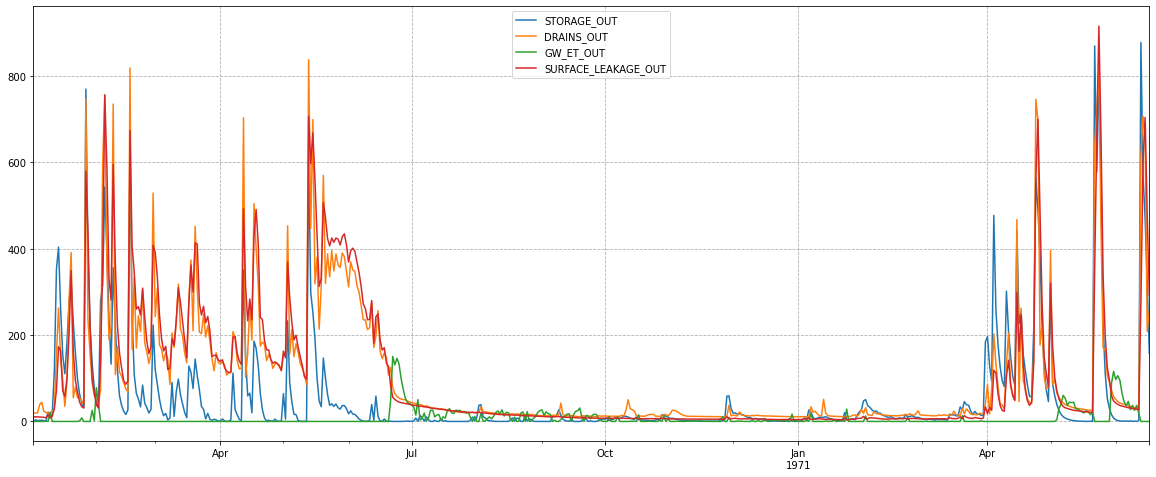

In [77]:
fig,ax = plt.subplots(figsize=(20,8))
#end_df.iloc[:,0].plot(ax=ax, legend=True)
#end_df.iloc[:,3].plot(ax=ax, legend=True)
#end_df.iloc[:,6].plot(ax=ax, legend=True)
end_df.iloc[:,7].plot(ax=ax, legend=True)
end_df.iloc[:,9].plot(ax=ax, legend=True)
end_df.iloc[:,11].plot(ax=ax, legend=True)
end_df.iloc[:,12].plot(ax=ax, legend=True)
#end_df.iloc[:,13].plot(ax=ax, legend=True)
ax.grid(ls='--')


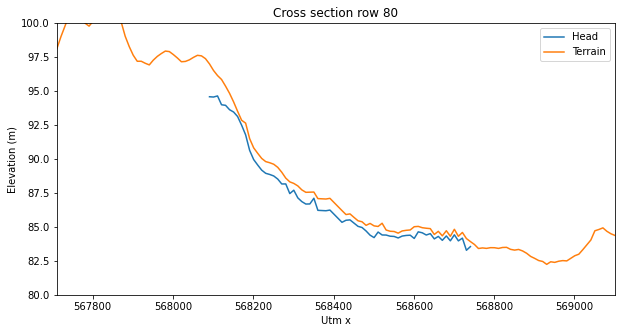

In [78]:
fig, ax = plt.subplots(figsize=(10, 5))
x = mf.dis.sr.xcentergrid[0]
ax.plot(x,head[0,80,:], label='Head')
ax.plot(x,mtop[80,:], label='Terrain')
ax.set_xlim(x.min(),x.max())
ax.set_ylim(80,100)
ax.set_xlabel("Utm x")
ax.set_ylabel("Elevation (m)")
ax.set_title('Cross section row 80')
ax.legend()
plt.show()
fig.savefig(os.path.join(figpth, 'Head_totime{}'.format(totim)+'.png'),
            transparent=False, bbox_inches='tight', pad_inches=0.05)

In [79]:
#simulated and observed head values. Calculating residual.
hydbinfn = os.path.join(workspace, modelname + '.hyd.bin')
hydpoo = flopy.utils.HydmodObs(hydbinfn).get_dataframe(timeunit='D')
hydpoo.drop('totim', axis=1, inplace=True)
hydpoo = hydpoo.iloc[1:]
sim_values = np.mean(hydpoo.values.tolist()[407:506], axis=0)
print(sim_values)
sim_index = hydpoo.columns.tolist()
sim_index_short = [i[6:] for i in sim_index]
del hydpoo
# obs
df = poo
# combined
df['sim'] = sim_values
df['res'] = df['mean'] - df['sim']
out = df[df.sim != -999]
df.to_csv(os.path.join(workspace, modelname + 'out_heads.dat'), float_format='%.4e')
HeadLocdf = df

[-999.           96.55968414   95.59423004   95.59423004   95.59423004
   95.10453958 -999.         -999.           85.80950041 -999.        ]


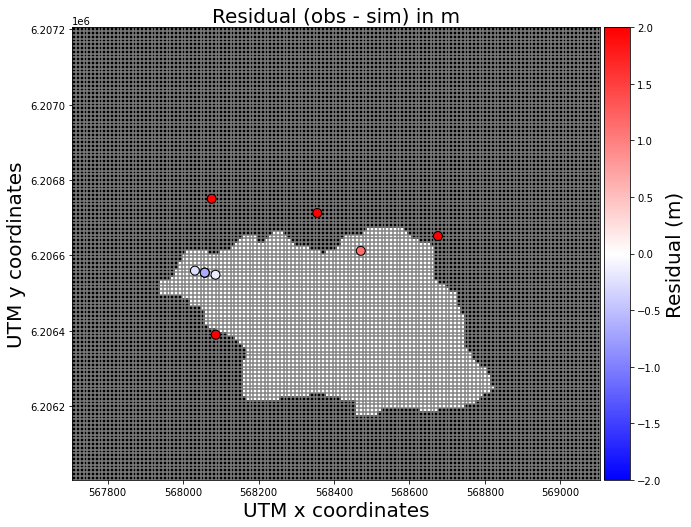

In [80]:
figzoom = 1
figheight = 10*figzoom
figwidth = figheight*(18/12)
fig,ax = plt.subplots(figsize=(figheight,figwidth))
modelmap = flopy.plot.PlotMapView(model=mf, layer=0) # create an instance of the ModelMap class
quadmesh = modelmap.plot_ibound()
obsc = ax.scatter((new_df['East']),
                  (new_df['North']),
                  c = HeadLocdf['res'],
                  s = 80, edgecolor='black',
                  cmap='bwr', vmax=2, vmin=-2,
                  zorder=5)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(obsc, cax=cax, shrink=0.5)
cb.set_label('Residual (m)', fontsize=20)
ax.set_title('Residual (obs - sim) in m',fontsize=20)
ax.set_ylabel('UTM y coordinates', fontsize=20)
ax.set_xlabel('UTM x coordinates', fontsize=20)
linecollection = modelmap.plot_grid()
fig.savefig(os.path.join(figpth,'mapview_head_residuals'),transparent=False, bbox_inches='tight', pad_inches=0.05)


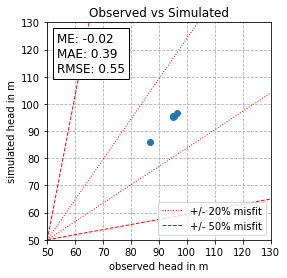

In [81]:
obs = HeadLocdf['mean'][HeadLocdf['sim']>-990]
sim = HeadLocdf['sim'][HeadLocdf['sim']>-990]
res = HeadLocdf['res'][HeadLocdf['sim']>-990]
data = pd.DataFrame({'obs':obs,'sim':sim})
#==============
# Set-up figure
#==============
fig,ax = plt.subplots(figsize=(4,4))
ax.scatter(obs,sim)
mn, mx = 50,130
ax.set_xlim(mn, mx)
ax.set_ylim(mn, mx)
ax.plot(np.asarray([mn, mx]), np.asarray([mn, mx * 0.8]), color='red', lw=1, ls=':', label='+/- 20% misfit')
ax.plot(np.asarray([mn, mx * 0.8]), np.asarray([mn, mx]), color='red', lw=1, ls=':')
ax.plot(np.asarray([mn, mx]), np.asarray([mn, mx * 0.5]), color='red', lw=1, ls='--', label='+/- 50% misfit')
ax.plot(np.asarray([mn, mx * 0.5]), np.asarray([mn, mx]), color='red', lw=1, ls='--')
#
step = 10.0
ax.set_xticks(np.arange(mn, mx + step, step))
ax.set_yticks(np.arange(mn, mx + step, step))
#
ax.grid()
ax.set_xlabel('observed head in m')
ax.set_ylabel('simulated head in m')
ax.legend(loc=4)
ax.grid(ls='--')
ax.set_title('Observed vs Simulated')
#================
# Annotate figure
#================
def calc_ME(data):
    """calculate mean error"""
    ME = (data['obs'] - data['sim']).mean()
    return np.round(ME, 2)
def calc_MAE(data):
    """calculate absolute mean error"""
    MAE = (data['obs'] - data['sim']).abs().mean()
    return np.round(MAE, 2)
def calc_RMSE(data):
    """Compute root-mean-square-error"""
    RMSE = np.sqrt(((data['obs'] - data['sim'])**2).mean())
    return np.round(RMSE, 2)
ax.annotate('ME: {0:.2f}\nMAE: {1:.2f}\nRMSE: {2:.2f}'.format(calc_ME(data),calc_MAE(data),calc_RMSE(data)),
            (0, 1), xytext=(10, -10),
            xycoords='axes fraction',
            textcoords='offset points',
            ha='left', va='top',
            fontsize=12,
            bbox=dict(alpha=1, fc='white'))

RMSE = calc_RMSE(data)
#============
# Save figure
#============
fig.savefig(os.path.join(figpth,'heads_obs_vs_sim_one2one'+' totim {}'.format(totim)),transparent=False, bbox_inches='tight', pad_inches=0.05)

In [82]:
#Getting simulated hydraulic heads for layer 1-5
heads_all_l0 = mfheads.get_alldata(mflay=0) 
heads_all_l1 = mfheads.get_alldata(mflay=1)
heads_all_l2 = mfheads.get_alldata(mflay=2) 
heads_all_l3 = mfheads.get_alldata(mflay=3)
heads_all_l4 = mfheads.get_alldata(mflay=4) 

In [83]:
#getting hydraulic heads from each F-3-X-D piezometer as a list
h_f_3_1_D = HeadLocdf.iloc[1][0:-3].tolist()
h_f_3_2_D = HeadLocdf.iloc[3][0:-3].tolist()
h_f_3_3_D = HeadLocdf.iloc[5][0:-3].tolist()

print(np.shape(h_f_3_1_D), np.shape(rch_df.iloc[407:507].index))

(100,) (100,)


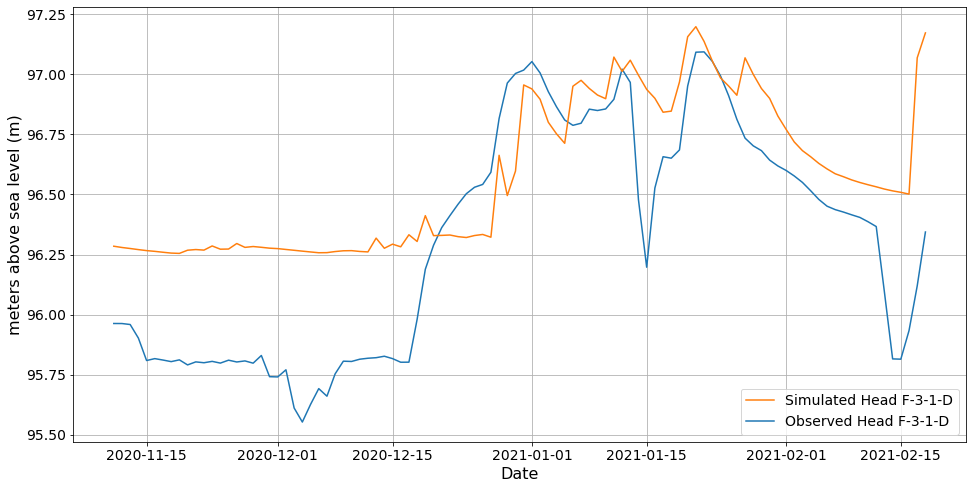

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(16,8))

obs_head_l0, = plt.plot(rch_df.iloc[407:507].index,h_f_3_1_D[:], ls='-', markersize=4)
sim_head_l0, = plt.plot(rch_df.iloc[407:507].index,heads_all_l0[407:507,hr[0],hc[0]], ls='-', markersize=4)

ax.grid()
ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('meters above sea level (m)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend([sim_head_l0, obs_head_l0],
           ['Simulated Head F-3-1-D', 'Observed Head F-3-1-D'],loc='lower right', fontsize=14)

fig.savefig(os.path.join(figpth, 'Transient_head_F_3_1_D'),transparent=False, bbox_inches='tight', pad_inches=0.05)

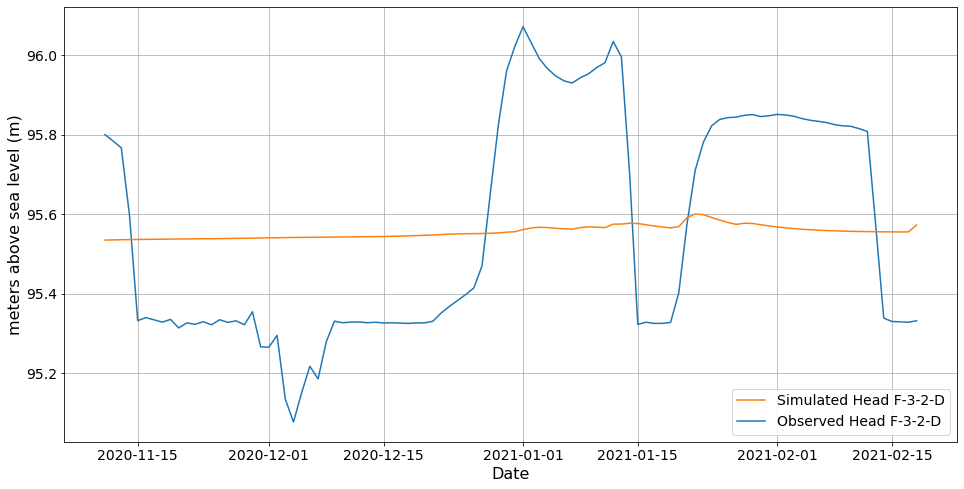

In [85]:
fig, ax = plt.subplots(1, 1, figsize=(16,8))

obs_head_l0, = plt.plot(rch_df.iloc[407:507].index,h_f_3_2_D[:], ls='-', markersize=4)
sim_head_l0, = plt.plot(rch_df.iloc[407:507].index,heads_all_l0[407:507,hr[1],hc[1]], ls='-', markersize=4)

ax.grid()
ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('meters above sea level (m)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend([sim_head_l0, obs_head_l0],
           ['Simulated Head F-3-2-D', 'Observed Head F-3-2-D'],loc='lower right', fontsize=14)

fig.savefig(os.path.join(figpth, 'Transient_head_F_3_2_D'),transparent=False, bbox_inches='tight', pad_inches=0.05)

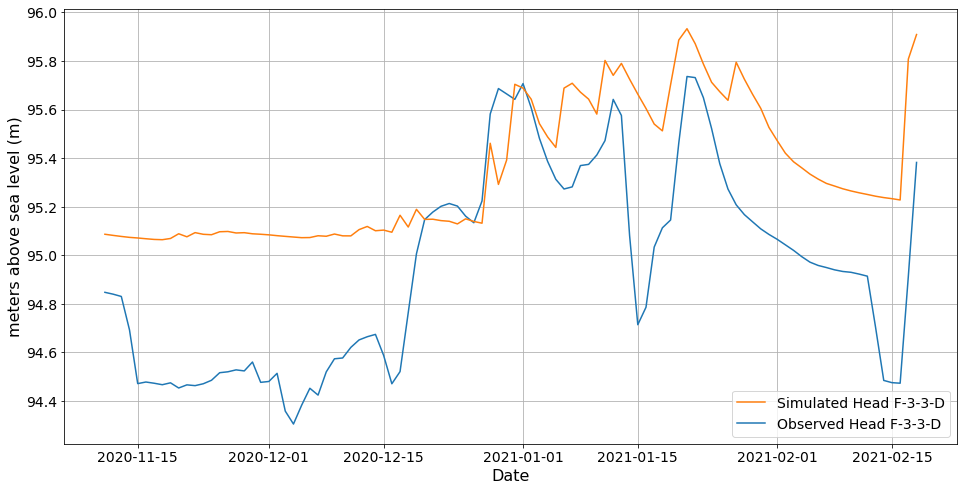

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(16,8))

obs_head_l0, = plt.plot(rch_df.iloc[407:507].index,h_f_3_3_D[:], ls='-', markersize=4)
sim_head_l0, = plt.plot(rch_df.iloc[407:507].index,heads_all_l0[407:507,hr[2],hc[2]], ls='-', markersize=4)

ax.grid()
ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('meters above sea level (m)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend([sim_head_l0, obs_head_l0],
           ['Simulated Head F-3-3-D', 'Observed Head F-3-3-D'],loc='lower right', fontsize=14)

fig.savefig(os.path.join(figpth, 'Transient_head_F_3_3_D'),transparent=False, bbox_inches='tight', pad_inches=0.05)

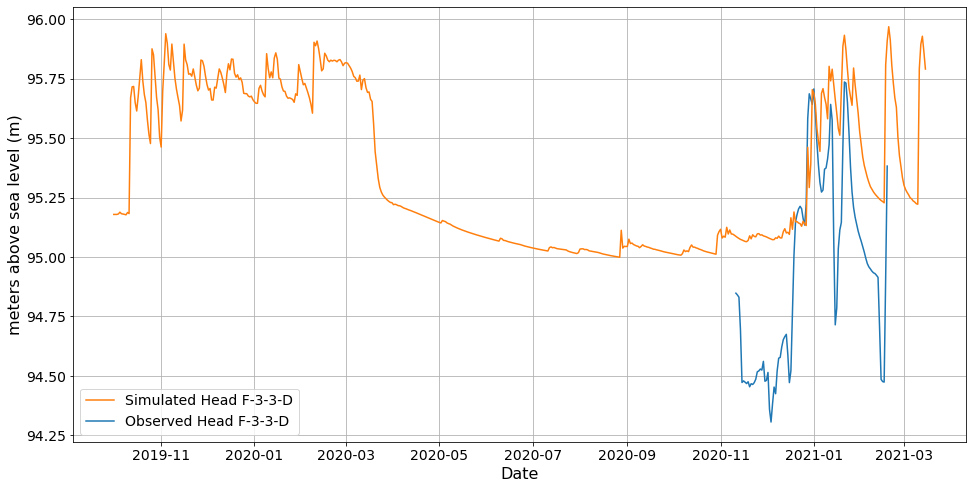

In [87]:
fig, ax = plt.subplots(1, 1, figsize=(16,8))

obs_head_l0, = plt.plot(rch_df.iloc[407:507].index,h_f_3_3_D[:], ls='-', markersize=4)
sim_head_l0, = plt.plot(rch_df.iloc[:].index,heads_all_l0[:,hr[2],hc[2]], ls='-', markersize=4)

ax.grid()
ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('meters above sea level (m)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend([sim_head_l0, obs_head_l0],
           ['Simulated Head F-3-3-D', 'Observed Head F-3-3-D'],loc='lower left', fontsize=14)

fig.savefig(os.path.join(figpth, 'Transient_head_F_3_3_D_all_times'),transparent=False, bbox_inches='tight', pad_inches=0.05)

In [88]:
#getting all drain informations
t0 = time.time()
drn_dict = {}
drn_arrays = []
drn_sum_all = []

for i in range(1,nper+1):
    drn_data = cbb.get_data(totim=i, text='DRAINS')
    drn_3D = cbb.create3D(drn_data[0], nlay, nrows, ncols)
    drn_arrays.append(drn_3D)
    drn_list = drn_data[0].tolist()
    drn_flux = list(zip(*drn_list))[1]
    drn_sum = sum(drn_flux)
    drn_sum_all.append(abs(drn_sum))
    
drn_dict[0] = drn_arrays

print(time.time()-t0)

1187.6128506660461


In [89]:
#load root zone water budget
uzfbdobjct = flopy.utils.CellBudgetFile(os.path.join('Fensholt_VoxelUZF/Fensholt_VoxelUZF.uzfcb2.bin'))

In [90]:
r = uzfbdobjct.get_data(text='UZF RECHARGE')
et = uzfbdobjct.get_data(text='GW ET')
sl = uzfbdobjct.get_data(text='SURFACE LEAKAGE')

r_all = []
et_all = []
sl_all = []
for i in range(len(r)):
    r_all.append(r[i][1])
    et_all.append(et[i][1])
    sl_all.append(sl[i][1])

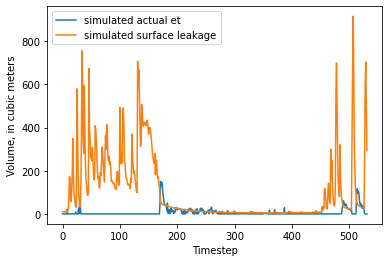

In [91]:
rtot = [rp.sum() for rp in r_all]
ettot = [etp.sum() for etp in et_all]
sltot = [sls.sum() for sls in sl_all]

#plt.plot(rtot, label='simulated recharge')
plt.plot(np.abs(ettot), label='simulated actual et')
plt.plot(np.abs(sltot), label='simulated surface leakage')
plt.xlabel('Timestep')
plt.ylabel('Volume, in cubic meters')
plt.legend();

In [92]:
#getting dates from the observed drainage
drain_comp_df = pd.DataFrame(rch_df, copy=True)
drain_comp_df = drain_comp_df[drain_comp_df.index > pd.to_datetime('2020-01-08')]
drain_comp_df = drain_comp_df[drain_comp_df.index < pd.to_datetime('2021-03-14')]

In [93]:
#getting the total discharge based on absolute values of drainage, evaporation and surface leakage, for each stress period
sltot_abs = [abs(sl_s) for sl_s in sltot]
ettot_abs = [abs(et_s) for et_s in ettot]
discharge_all = []
for i in range(nper):
    discharge_all.append(drn_sum_all[i]+sltot_abs[i])

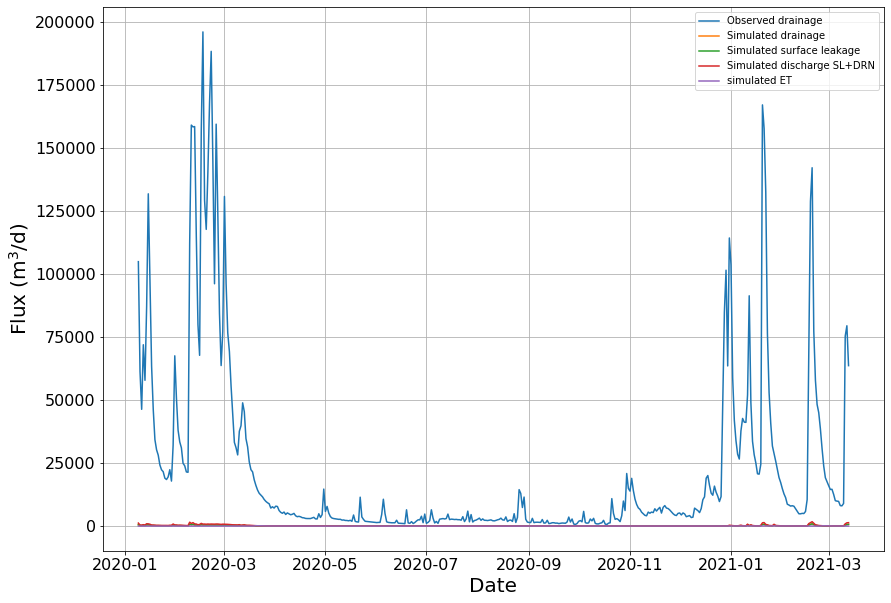

In [94]:
fig, ax = plt.subplots(1, 1, figsize=(14,10))
data_drn, = plt.plot(drain_comp_df.index, data_comp)
sim_drn, = plt.plot(drain_comp_df.index, drn_sum_all[100:-2], ls='-', markersize=4)
sim_sl, = plt.plot(drain_comp_df.index, sltot_abs[100:-2], ls='-', markersize=4)
sim_dis, = plt.plot(drain_comp_df.index, discharge_all[100:-2], ls='-', markersize=4)
sim_et, = plt.plot(drain_comp_df.index, ettot_abs[100:-2], ls='-', markersize=4)




ax.grid()
ax.set_ylabel('Flux (m$^3$/d)', fontsize=20)
ax.set_xlabel('Date', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#secax = ax.twinx()
#data_df['Precipitation (mm)'].plot(ax=secax, color='black', linewidth=0.5)
#secax.invert_yaxis()

plt.show;
plt.legend([data_drn,sim_drn,sim_sl,sim_dis,sim_et],
           ['Observed drainage','Simulated drainage','Simulated surface leakage','Simulated discharge SL+DRN','simulated ET'],loc='upper right');

fig.savefig(os.path.join(figpth, 'Transient_drainage_sim_vs_obs'),transparent=False, bbox_inches='tight', pad_inches=0.05)

In [95]:
drn_vol_sum = sum(drn_sum_all)
uzf_vol_sum = sum(sltot_abs)+sum(ettot_abs)
dis_vol_sum = sum(discharge_all)+sum(ettot_abs)

drn_relative = 100-((dis_vol_sum-drn_vol_sum)/dis_vol_sum)*100
uzf_relative = 100-((dis_vol_sum-uzf_vol_sum)/dis_vol_sum)*100
print(drn_relative, uzf_relative)

47.680120062684715 52.31987993731539


In [96]:
#four seasons relative discharge dataframe
spring_iloc1 = len(rch_df[rch_df.index < '2020-03-01'])
summer_iloc = len(rch_df[rch_df.index < '2020-06-01'])
autumn_iloc = len(rch_df[rch_df.index < '2020-09-01'])
winter_iloc = len(rch_df[rch_df.index < '2020-12-01'])
spring_iloc2 = len(rch_df[rch_df.index < '2021-03-01'])

spring_uzf = sum(sltot_abs[spring_iloc1:summer_iloc])
spring_drn = sum(drn_sum_all[spring_iloc1:summer_iloc])
spring_et = sum(ettot_abs[spring_iloc1:summer_iloc])
spring_dis = sum(discharge_all[spring_iloc1:summer_iloc])+sum(ettot_abs[spring_iloc1:summer_iloc])
spring_drn_relative = 100-((spring_dis-spring_drn)/spring_dis)*100
spring_uzf_relative = 100-((spring_dis-spring_uzf)/spring_dis)*100
spring_et_relative = 100-((spring_dis-spring_et)/spring_dis)*100

summer_uzf = sum(sltot_abs[summer_iloc:autumn_iloc])
summer_drn = sum(drn_sum_all[summer_iloc:autumn_iloc])
summer_et = sum(ettot_abs[summer_iloc:autumn_iloc])
summer_dis = sum(discharge_all[summer_iloc:autumn_iloc])+sum(ettot_abs[summer_iloc:autumn_iloc])
summer_drn_relative = 100-((summer_dis-summer_drn)/summer_dis)*100
summer_uzf_relative = 100-((summer_dis-summer_uzf)/summer_dis)*100
summer_et_relative = 100-((summer_dis-summer_et)/summer_dis)*100

autumn_uzf = sum(sltot_abs[autumn_iloc:winter_iloc])
autumn_drn = sum(drn_sum_all[autumn_iloc:winter_iloc])
autumn_et = sum(ettot_abs[autumn_iloc:winter_iloc])
autumn_dis = sum(discharge_all[autumn_iloc:winter_iloc])+sum(ettot_abs[autumn_iloc:winter_iloc])
autumn_drn_relative = 100-((autumn_dis-autumn_drn)/autumn_dis)*100
autumn_uzf_relative = 100-((autumn_dis-autumn_uzf)/autumn_dis)*100
autumn_et_relative = 100-((autumn_dis-autumn_et)/autumn_dis)*100

winter_uzf = sum(sltot_abs[winter_iloc:spring_iloc2])
winter_drn = sum(drn_sum_all[winter_iloc:spring_iloc2])
winter_et = sum(ettot_abs[winter_iloc:spring_iloc2])
winter_dis = sum(discharge_all[winter_iloc:spring_iloc2])+sum(ettot_abs[winter_iloc:spring_iloc2])
winter_drn_relative = 100-((winter_dis-winter_drn)/winter_dis)*100
winter_uzf_relative = 100-((winter_dis-winter_uzf)/winter_dis)*100
winter_et_relative = 100-((winter_dis-winter_et)/winter_dis)*100


index = ['surface leakage discharge', 'discharge by drains', 'ET', 'total discharge', 'relative discharge by drains (%)', 'relative surface leakage discharge (%)', 'relative ET (%)']

f_season = {'spring': [spring_uzf, spring_drn, spring_et, spring_dis, spring_drn_relative, spring_uzf_relative, spring_et_relative],
            'summer': [summer_uzf, summer_drn, summer_et, summer_dis, summer_drn_relative, summer_uzf_relative, summer_et_relative],
            'autumn': [autumn_uzf, autumn_drn, autumn_et, autumn_dis, autumn_drn_relative, autumn_uzf_relative, autumn_et_relative],
            'winter': [winter_uzf, winter_drn, winter_et, winter_dis, winter_drn_relative, winter_uzf_relative, winter_et_relative]}

f_season_df = pd.DataFrame(data=f_season, index=index)

In [97]:
f_season_df.head(10)

,spring,summer,autumn,winter
surface leakage discharge,6431.928866,660.895697,516.515590,9338.651894
discharge by drains,6212.777638,1366.471495,1355.846060,9674.568346
ET,1873.411590,406.994156,131.022238,989.346547
total discharge,14518.118094,2434.361347,2003.383889,20002.566787
relative discharge by drains (%),42.793271,56.132648,67.677796,48.366634
relative surface leakage discharge (%),44.302773,27.148628,25.782158,46.687268
relative ET (%),12.903956,16.718724,6.540047,4.946098


In [98]:
sl_data = uzfbdobjct.get_data(text='SURFACE LEAKAGE')
print(np.shape(sl_data))

#getting summed surface leakage values from the entire grid for each season
sl_all_grid = np.zeros([nrows,ncols])
sl_spring_grid = np.zeros([nrows,ncols])
sl_summer_grid = np.zeros([nrows,ncols])
sl_autumn_grid = np.zeros([nrows,ncols])
sl_winter_grid = np.zeros([nrows,ncols])

for i in range(np.shape(sl_data)[0]):
    sl = sl_data[i][1][:,:]
    sl_all_grid[:,:] = sl_all_grid[:,:] + sl
    if i in range(spring_iloc1,summer_iloc):
        sl_spring_grid[:,:] = sl_spring_grid[:,:] + sl
    if i in range(summer_iloc,autumn_iloc):
        sl_summer_grid[:,:] = sl_summer_grid[:,:] + sl
    if i in range(autumn_iloc,winter_iloc):
        sl_autumn_grid[:,:] = sl_autumn_grid[:,:] + sl
    if i in range(winter_iloc,spring_iloc2):
        sl_winter_grid[:,:] = sl_winter_grid[:,:] + sl


(532, 2, 120, 140)


In [99]:
#getting summed drain values from the entire grid for each season
drn_all_grid = np.zeros([nrows,ncols])
drn_spring_grid = np.zeros([nrows,ncols])
drn_summer_grid = np.zeros([nrows,ncols])
drn_autumn_grid = np.zeros([nrows,ncols])
drn_winter_grid = np.zeros([nrows,ncols])

for i in range(nper):
    drn_all_grid = drn_all_grid + drn_arrays[i]
    if i in range(spring_iloc1,summer_iloc):
        drn_spring_grid = drn_spring_grid + drn_arrays[i]
    if i in range(summer_iloc,autumn_iloc):
        drn_summer_grid = drn_summer_grid + drn_arrays[i]
    if i in range(autumn_iloc,winter_iloc):
        drn_autumn_grid = drn_autumn_grid + drn_arrays[i]
    if i in range(winter_iloc,spring_iloc2):
        drn_winter_grid = drn_winter_grid + drn_arrays[i]


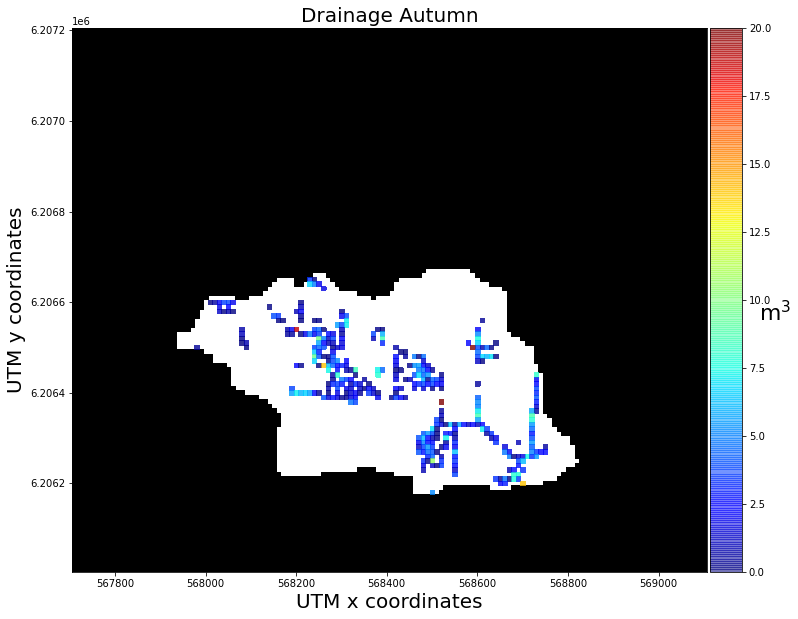

In [100]:
# Plot the heads for a defined layer and boundary conditions
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1)
modelmap = flopy.plot.PlotMapView(model=mf, layer=1)
#quadmesh = modelmap.plot_grid()
quadmesh = modelmap.plot_ibound()
#quadmesh = modelmap.plot_bc('drn')
quadmesh = modelmap.plot_array(abs(drn_autumn_grid), masked_values=[0], alpha=0.55,cmap='jet', clim=(0, 20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(quadmesh, cax=cax, shrink=0.5)
cb.set_label(label='m$^3$', rotation=0, fontsize=22)
ax.set_title('Drainage Autumn', fontsize=20);
ax.set_ylabel('UTM y coordinates', fontsize=20)
ax.set_xlabel('UTM x coordinates', fontsize=20)

fig.savefig(os.path.join(figpth, 'mapview_DRN_autumn'),transparent=False, bbox_inches='tight', pad_inches=0.05)

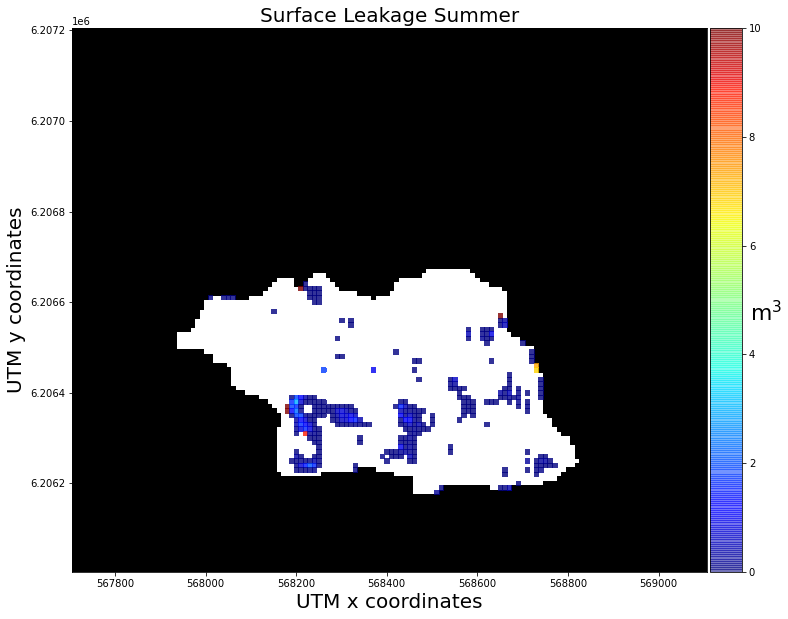

In [101]:
# Plot the heads for a defined layer and boundary conditions
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1)
modelmap = flopy.plot.PlotMapView(model=mf, layer=0)
#quadmesh = modelmap.plot_grid()
quadmesh = modelmap.plot_ibound()
#quadmesh = modelmap.plot_bc('drn')
quadmesh = modelmap.plot_array(abs(sl_summer_grid), masked_values=[0], alpha=0.55,cmap='jet', clim=(0, 10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(quadmesh, cax=cax, shrink=0.5)
cb.set_label(label='m$^3$', rotation=0, fontsize=22)
ax.set_title('Surface Leakage Summer', fontsize=20)
ax.set_ylabel('UTM y coordinates', fontsize=20)
ax.set_xlabel('UTM x coordinates', fontsize=20)

fig.savefig(os.path.join(figpth, 'mapview_SL_summer'),transparent=False, bbox_inches='tight', pad_inches=0.05)

In [102]:
discharge_df = pd.DataFrame({'drn dis': [drn_sum_all],
                            'surface_leakage': [sltot_abs],
                            'ET': [ettot_abs],
                            'total discharge': [discharge_all+ettot_abs]})

In [103]:
#exporting total discharge and seasonal discharges  
discharge_df.to_csv(os.path.join(workspace,'discharge_df.csv'))
f_season_df.to_csv(os.path.join(workspace,'four_season_df.csv'))

In [104]:
#getting simulated and observed values in same shape
np_sim = np.array([discharge_all[100:-2]])
np_obs = data_comp.to_numpy().reshape(np.shape(np_sim))

In [105]:
nse_eval = hydroeval.evaluator(hydroeval.nse, np_sim, np_obs, axis=1)
print('NSE = {}'.format(nse_eval))
pbias_eval = hydroeval.evaluator(hydroeval.pbias, np_sim, np_obs, axis=1)
print('PBIAS = {}'.format(pbias_eval))

NSE = [-0.33862393]
PBIAS = [99.2399599]


In [106]:
#converting HIP infiltration to m^3/d
rch_df = rch_df/1000 #getting rch in m/d
rch_df = rch_df*(len(result1['cellids'])*10*10) #multiplied by area to get m^3 where result1['cellids'] is the number of cells in layer0

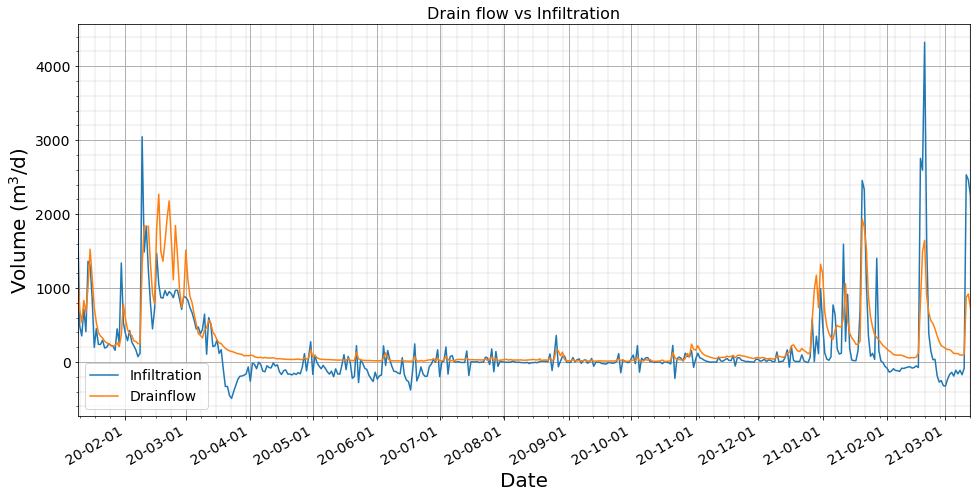

In [107]:
#water balance check
# Create figure and plot space
fig, ax = plt.subplots(figsize=(16, 8))

# Add x-axis and y-axis
dat1, = ax.plot(rch_df.index.values, 
                rch_df['rech bbox'], label='Infiltration')

dat2, = ax.plot(drain_df.index.values, 
                drain_df['Fens'], label='Drainflow')

# Set title and labels for axes

ax.set(xlim=["2020-01-09", "2021-03-13"])

ax.set_xlabel("Date", fontsize=20)
ax.set_ylabel("Volume (m$^3$/d)", fontsize=20)
ax.set_title("Drain flow vs Infiltration", fontsize=16)


# Define the date format
date_form = mdates.DateFormatter("%y-%m-%d")
ax.xaxis.set_major_formatter(date_form)

#Setting major locator for y axis
#ax.set_yticks(np.linspace(round(ax.get_ybound()[0]), round(ax.get_ybound()[1]), 5))

# Ensure a major x tick for each week using (interval=1)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.minorticks_on()
ax.grid(which='major', linewidth=1)
ax.grid(which='minor', linewidth=0.3)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.legend(loc='lower left', fontsize=14)

fig.autofmt_xdate()

plt.show()
fig.savefig(os.path.join(figpth,'Drainflow_vs_Infiltration_1'))

In [108]:
rch_cal = rch_df[rch_df.index >= '2020-03-01']
rch_cal = rch_cal[rch_cal.index < '2021-03-01']
rch_cal[rch_cal['rech bbox']>0] = 0
print('The estimated groundwater evaporation from the HIP infiltration model:', rch_cal.sum())
rch_cal = rch_df[rch_df.index >= '2020-03-01']
rch_cal = rch_cal[rch_cal.index < '2021-03-01']
rch_cal[rch_cal['rech bbox']<0] = 0
print('The estimated infiltration from the HIP infiltration model:', rch_cal.sum())

The estimated groundwater evaporation from the HIP infiltration model: 0
rech bbox                    -17914.037266
rech bbox w/o river          -18118.066853
rech drain catch             -21462.941714
rech drain catch w/o paved   -23277.737555
Pnet drain catch             -75665.825252
dtype: float64
The estimated infiltration from the HIP infiltration model: 0
rech bbox                     43939.945065
rech bbox w/o river           44234.860013
rech drain catch              49051.587770
rech drain catch w/o paved    48595.147300
Pnet drain catch              96104.140051
dtype: float64


In [109]:
f = open(os.path.join(figpth, 'Important variables'),"w")
f.write('Threshold = {}'.format(threshold)+'\n')
f.write(str(k_values)+'\n')
f.write(str(sy_values)+'\n')
f.write('Drain elevation = {}'.format(drn_elev)+'\n')
f.write('Drain conductance = {}'.format(drncond)+'\n')
f.write('RMSE = {}'.format(RMSE)+'\n')
f.write('NSE = {}'.format(nse_eval.min())+'\n')
f.write('PBIAS = {}'.format(pbias_eval.min())+'\n')
f.write('Drain discharge relative to total discharge = {} %'.format(drn_relative)+'\n')
f.write('UZF discharge relative to total discharge = {} %'.format(uzf_relative)+'\n')
f.close()

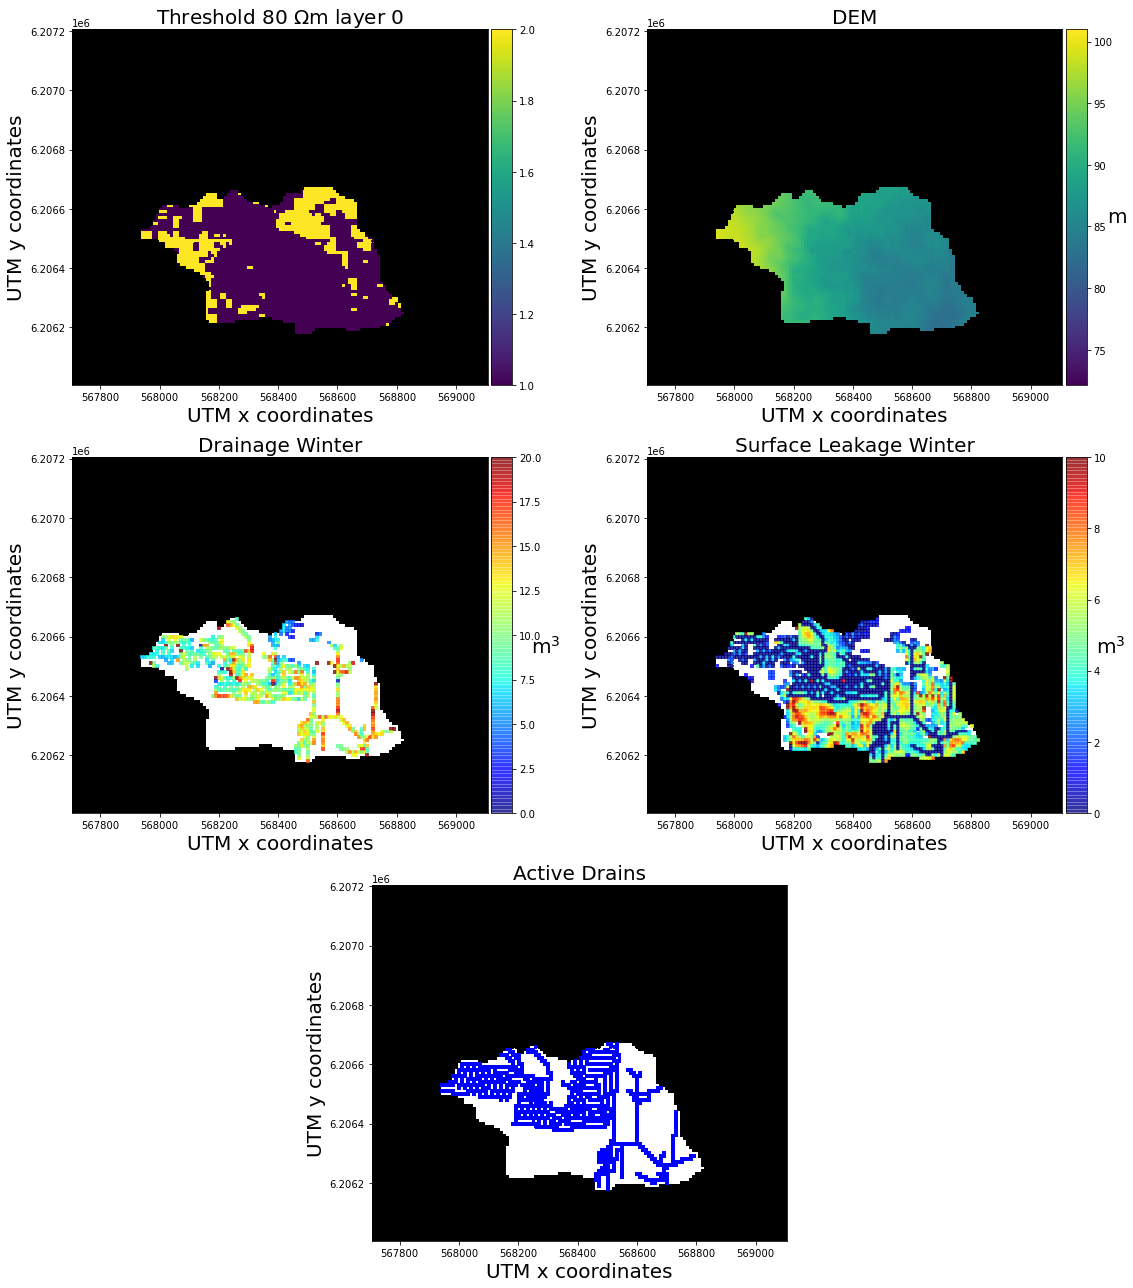

In [110]:
# Plot of risk assessment
fig = plt.figure(figsize=(16, 18))
gs = mpl.gridspec.GridSpec(nrows=3, ncols=2, height_ratios=[1, 1, 1])

ax0 = fig.add_subplot(gs[0, 0])
pmv = flopy.plot.PlotMapView(model=mf, layer=0)
quadmesh = pmv.plot_array(hks[0])
i_mesh = pmv.plot_ibound()
ax0.set_title('Threshold 80 $\Omega$m layer 0', fontsize = 20)
divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(quadmesh, cax=cax, shrink=0.5)
ax0.set_ylabel('UTM y coordinates', fontsize=20)
ax0.set_xlabel('UTM x coordinates', fontsize=20)

ax1 = fig.add_subplot(gs[0, 1])
pmv = flopy.plot.PlotMapView(model=mf, layer=0)
quadmesh = pmv.plot_array(dem_data)
i_mesh = pmv.plot_ibound()
ax1.set_title('DEM', fontsize = 20)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(quadmesh, cax=cax, shrink=0.5)
cb.set_label(label='m', rotation=0, fontsize=20)
ax1.set_ylabel('UTM y coordinates', fontsize=20)
ax1.set_xlabel('UTM x coordinates', fontsize=20)

ax2 = fig.add_subplot(gs[1, 0])
modelmap = flopy.plot.PlotMapView(model=mf, layer=1)
imesh = modelmap.plot_ibound()
quadmesh = modelmap.plot_array(abs(drn_winter_grid), masked_values=[0], alpha=0.55,cmap='jet', clim=(0, 20))
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(quadmesh, cax=cax, shrink=0.5)
cb.set_label(label='m$^3$', rotation=0, fontsize=20)
ax2.set_title('Drainage Winter', fontsize=20);
ax2.set_ylabel('UTM y coordinates', fontsize=20)
ax2.set_xlabel('UTM x coordinates', fontsize=20)

ax3 = fig.add_subplot(gs[1, 1])
modelmap = flopy.plot.PlotMapView(model=mf, layer=0)
quadmesh = modelmap.plot_ibound()
quadmesh = modelmap.plot_array(abs(sl_winter_grid), masked_values=[0], alpha=0.55,cmap='jet', clim=(0, 10))
divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(quadmesh, cax=cax, shrink=0.5)
cb.set_label(label='m$^3$', rotation=0, fontsize=20)
ax3.set_title('Surface Leakage Winter', fontsize=20)
ax3.set_ylabel('UTM y coordinates', fontsize=20)
ax3.set_xlabel('UTM x coordinates', fontsize=20)

ax4 = fig.add_subplot(gs[2:, :])
modelmap = flopy.plot.PlotMapView(model=mf, layer=1)
#quadmesh = modelmap.plot_grid()
quadmesh = modelmap.plot_ibound()
quadmesh = modelmap.plot_bc('drn', color='blue')
ax4.set_title('Active Drains', fontsize=20)
ax4.set_ylabel('UTM y coordinates', fontsize=20)
ax4.set_xlabel('UTM x coordinates', fontsize=20)

plt.tight_layout()
plt.show()

#fig.set_size_inches(11.69,8.27)

fig.savefig(os.path.join(figpth, 'risk_assesment'), dpi=150, transparent=False, bbox_inches='tight', pad_inches=0.05)